In [1]:
ls

Stock Model.ipynb      individual_stocks_5yr/
getSandP.py            merge.sh


In [2]:
cd individual_stocks_5yr

/Users/nathanavery/Library/Mobile Documents/com~apple~CloudDocs/Desktop/StockProject/archive/individual_stocks_5yr


In [3]:
ls

__MACOSX/              individual_stocks_5yr/


In [4]:
cd individual_stocks_5yr

/Users/nathanavery/Library/Mobile Documents/com~apple~CloudDocs/Desktop/StockProject/archive/individual_stocks_5yr/individual_stocks_5yr


In [6]:
stonks = !ls

In [8]:
type(stonks)

IPython.utils.text.SList

In [10]:
print(stonks[0:5])

['AAL_data.csv', 'AAPL_data.csv', 'AAP_data.csv', 'ABBV_data.csv', 'ABC_data.csv']


We can see from the list above that each stock has its own csv file over the given five-year period. 
Ultimately, what do we need our data to look like? Clearly this is too much information. 

The (pen)ultimate goal here is to have an array of time-ordered dataframes, whose columns are comprised of 
statistics gleaned from rolling 3-year subperiods, seperated by one week, spanning the five year dataset, for which each record represents a single stock. This will allow an ML model to easily determine multicolinearity amongst the various statistics (techincally parameters, as we are studying the entire population of the S&P 500.) 

Those parameters will be:
    <br> &emsp; Measures of volatility: Beta, StDev, Max Drawdown
    <br >&emsp; A measure of size: Daily Trading Volume
    <br>&emsp; Measures of momentum: Moving Averages (7w, 14w), Relative Strength
    
NOTE: Some of these statistics require only 2-values to compute (beginning and end over a time period) while others require each value across that entire period. 

In [14]:
#First we're going to want a master dataframe with the price and volume for every stock over the five year period.

!cd ..

In [16]:
!cd ../..

In [17]:
!ls

AAL_data.csv   CMCSA_data.csv GLW_data.csv   MET_data.csv   SCG_data.csv
AAPL_data.csv  CME_data.csv   GM_data.csv    MGM_data.csv   SCHW_data.csv
AAP_data.csv   CMG_data.csv   GOOGL_data.csv MHK_data.csv   SEE_data.csv
ABBV_data.csv  CMI_data.csv   GOOG_data.csv  MKC_data.csv   SHW_data.csv
ABC_data.csv   CMS_data.csv   GPC_data.csv   MLM_data.csv   SIG_data.csv
ABT_data.csv   CNC_data.csv   GPN_data.csv   MMC_data.csv   SJM_data.csv
ACN_data.csv   CNP_data.csv   GPS_data.csv   MMM_data.csv   SLB_data.csv
ADBE_data.csv  COF_data.csv   GRMN_data.csv  MNST_data.csv  SLG_data.csv
ADI_data.csv   COG_data.csv   GS_data.csv    MON_data.csv   SNA_data.csv
ADM_data.csv   COL_data.csv   GT_data.csv    MOS_data.csv   SNI_data.csv
ADP_data.csv   COO_data.csv   GWW_data.csv   MO_data.csv    SNPS_data.csv
ADSK_data.csv  COP_data.csv   HAL_data.csv   MPC_data.csv   SO_data.csv
ADS_data.csv   COST_data.csv  HAS_data.csv   MRK_data.csv   SPGI_data.csv
AEE_data.csv   COTY_data.csv  HBAN_data.csv  MRO_

In [146]:
#First we seek to create a master dataframe.
import pandas as pd, numpy as np

giant_df = pd.DataFrame()
for stonk in stonks:
    try:
        stonk_df = pd.read_csv(stonk)
        giant_df = giant_df.append(stonk_df)
    except:
        pass

In [147]:
print(giant_df)

            date   open   high    low  close    volume Name
0     2013-02-08  15.07  15.12  14.63  14.75   8407500  AAL
1     2013-02-11  14.89  15.01  14.26  14.46   8882000  AAL
2     2013-02-12  14.45  14.51  14.10  14.27   8126000  AAL
3     2013-02-13  14.30  14.94  14.25  14.66  10259500  AAL
4     2013-02-14  14.94  14.96  13.16  13.99  31879900  AAL
...          ...    ...    ...    ...    ...       ...  ...
1254  2018-02-01  76.84  78.27  76.69  77.82   2982259  ZTS
1255  2018-02-02  77.53  78.12  76.73  76.78   2595187  ZTS
1256  2018-02-05  76.64  76.92  73.18  73.83   2962031  ZTS
1257  2018-02-06  72.74  74.56  72.13  73.27   4924323  ZTS
1258  2018-02-07  72.70  75.00  72.69  73.86   4534912  ZTS

[619040 rows x 7 columns]


In [148]:
#Okay, that took a minute. I'm going to want to pickle the result for future use. 
import pickle
import os

!pwd

/Users/nathanavery/Library/Mobile Documents/com~apple~CloudDocs/Desktop/StockProject/archive/individual_stocks_5yr/individual_stocks_5yr


In [149]:
#Pickle the dataframe
directory = '/Users/nathanavery/Library/Mobile Documents/com~apple~CloudDocs/Desktop/StockProject/archive/'
filename = 'giant_df.p'
filepath = os.path.join(directory, filename)
with open(filepath, 'wb') as file:
    pickle.dump(giant_df, file)

In [144]:
print(filepath)

/Users/nathanavery/Library/Mobile Documents/com~apple~CloudDocs/Desktop/StockProject/archive/giant_df.p


In [337]:
#Unpickle it
directory = '/Users/nathanavery/Library/Mobile Documents/com~apple~CloudDocs/Desktop/StockProject/archive/'
filename = 'giant_df.p'
filepath = os.path.join(directory, filename)
with open(filepath, 'rb') as file:
    giant_df = pickle.load(file)

In [338]:
#We'll want to multiindex this according to each stock name, followed by the date.

midx = [giant_df.Name, giant_df.date]
giant_df.drop(columns=['Name', 'date', 'high', 'low', 'open'], inplace=True)
master_df = pd.DataFrame(giant_df.values, columns = giant_df.columns, index=midx)

In [339]:
master_df.head()

close      volume
Name date                         
AAL  2013-02-08  14.75   8407500.0
     2013-02-11  14.46   8882000.0
     2013-02-12  14.27   8126000.0
     2013-02-13  14.66  10259500.0
     2013-02-14  13.99  31879900.0

In [340]:
#Now what about the problem of incomplete data? We happen to have stocks with some missing dates. We might think 
#about interpolating the missing data, but I would argue that we don't need to bother with this. There is plenty 
#to work with given that we're only missing data on 35 stocks. 

#Let's identify the traitors first.
from ordered_set import OrderedSet
stonk_names = OrderedSet(master_df.index.get_level_values(0))
num_records = {stonk : len(master_df.loc[stonk]) for stonk in stonk_names} 
required_records = max(num_records.values())
outcasts = [stonk for stonk in stonk_names if num_records[stonk] < required_records]
print(len(outcasts))
print(outcasts)

35
['ALLE', 'APTV', 'BHF', 'BHGE', 'BMY', 'CFG', 'COTY', 'CSRA', 'DHR', 'DWDP', 'DXC', 'ES', 'EVHC', 'FOXA', 'FOX', 'FTV', 'GOOG', 'HLT', 'HPE', 'HPQ', 'ICE', 'INFO', 'IQV', 'KHC', 'NAVI', 'NWSA', 'NWS', 'ORCL', 'O', 'PYPL', 'QRVO', 'SYF', 'UA', 'WLTW', 'WRK']


In [341]:
#Interesting. Google's on there. So's Oracle. Both are major companies. Well, we'll be able to live without them,
#here as in the real world.

master_df.drop(outcasts, axis=0, level=0, inplace=True)
print(master_df)

                 close      volume
Name date                         
AAL  2013-02-08  14.75   8407500.0
     2013-02-11  14.46   8882000.0
     2013-02-12  14.27   8126000.0
     2013-02-13  14.66  10259500.0
     2013-02-14  13.99  31879900.0
...                ...         ...
ZTS  2018-02-01  77.82   2982259.0
     2018-02-02  76.78   2595187.0
     2018-02-05  73.83   2962031.0
     2018-02-06  73.27   4924323.0
     2018-02-07  73.86   4534912.0

[591730 rows x 2 columns]


In [342]:
#Ultimately, everything we need can be derived from this. First, we'll need a representation of the index as a whole.

SPY_df = master_df.groupby('date').mean()

name_idx = pd.Series(['SPY' for i in range(len(SPY_df))], name = 'Name')

SPY_df.index = [name_idx, SPY_df.index]

master_df = master_df.append(SPY_df)

master_df.rename({'close' : 'Price', 'volume': 'Volume'}, axis=1, inplace=True) 
master_df.index.set_names('Date', level=1, inplace=True) 
print(master_df)

                      Price        Volume
Name Date                                
AAL  2013-02-08   14.750000  8.407500e+06
     2013-02-11   14.460000  8.882000e+06
     2013-02-12   14.270000  8.126000e+06
     2013-02-13   14.660000  1.025950e+07
     2013-02-14   13.990000  3.187990e+07
...                     ...           ...
SPY  2018-02-01  114.575660  4.890722e+06
     2018-02-02  112.436766  5.470713e+06
     2018-02-05  108.312574  7.187073e+06
     2018-02-06  109.886085  8.117498e+06
     2018-02-07  109.533457  5.710445e+06

[592989 rows x 2 columns]


In [343]:
print(master_df.loc['SPY','Price'][0], master_df.loc['SPY','Price'][-1])

58.588572765957466 109.53345744680847


In [ ]:
#So we've finally got everything in one dataframe, but that dataframe is only the source from which we must derive 
#subsequent rolling data frames, each of which much contain parameters we derive solely from price movement. Volume
#is our only out-of-the box preloaded parameter.

#The first and most fundamental parameter that we'll need is a measure of returns. Technically, we would 
#calculate this as excess returns over the risk-free rate (and perhaps also inflation) by importing and 
#concatenating more data from other sources over this 5 year period; however, this is useful only when we 
#wish to evaluate the effectiveness of investment strategies outside the equities market. 

#That is beyond the scope of this project. 

#Thus we will evaluate returns simply by dividing the price of an equity by its initial value at the beginning of
#a timeframe. We will perform the same operation on the index. Ultimately, we will add a third measure, 
#excess returns, (not to be confused with the concept of the same name comparing returns to the risk-free rate)
#comparing the returns of a stock to the returns of the index to which it belongs. 

In [114]:
#DEPRECATED#

# df = master_df
# baseline_prices = pd.Series([df.loc[row[0][0],'Price'][0] for row in df.iterrows()], index = df.index)

In [391]:
#The prior operation too so long as to necessitate the use of more verbose yet more efficient code.

from ordered_set import OrderedSet

def returns_series(source_df):    
    df = source_df
    lst_prices = list()
    for name in OrderedSet(df.index.get_level_values(0)):
        current_stonk_prices = df.loc[name, 'Price']
        num_prices = len(current_stonk_prices)
        current_stonk_baseline = current_stonk_prices[0]
        baseline_column = [current_stonk_baseline for i in range(num_prices)]
        lst_prices += baseline_column

    baseline_prices = pd.Series(lst_prices, index = df.index)
    output = source_df.Price / baseline_prices
    output._name = 'Returns'
    return output

In [345]:
returns_series(master_df)

Name  Date      
AAL   2013-02-08    1.000000
      2013-02-11    0.980339
      2013-02-12    0.967458
      2013-02-13    0.993898
      2013-02-14    0.948475
                      ...   
SPY   2018-02-01    1.955597
      2018-02-02    1.919090
      2018-02-05    1.848698
      2018-02-06    1.875555
      2018-02-07    1.869536
Name: Returns, Length: 592989, dtype: float64

In [346]:
#Seems like a good place to save.
directory = '/Users/nathanavery/Library/Mobile Documents/com~apple~CloudDocs/Desktop/StockProject/archive/'
filename = 'master_df.p'
filepath = os.path.join(directory, filename)
with open(filepath, 'wb') as file:
    pickle.dump(master_df, file)

In [347]:
#To unpickle:
directory = '/Users/nathanavery/Library/Mobile Documents/com~apple~CloudDocs/Desktop/StockProject/archive/'
filename = 'master_df.p'
filepath = os.path.join(directory, filename)
with open(filepath, 'rb') as file:
    master_df = pickle.load(file)

In [348]:
#VOLATILITY FUNCTIONS#

#We're going to be considering the following three volatility functions: beta, standard deviation, and max drawdown.

#Let's build one. Suppose we want to get beta for AAL. The definition for beta is cov(AAL, SPY)/var(SPY), 
#which for simplicity of programming we might express as cov(AAL, SPY)/cov(SPY, SPY). Then, supposing our dataframe
#has been pre-sliced to measure the desired time-period, we build the following function:

def beta(stonk_name, index_name, source_df):
    returns_df = pd.DataFrame()
    for name in stonk_name, index_name:
        prices = source_df.loc[name,'Price']
        returns = prices / prices[0]
        returns._name = name
        returns_df = pd.concat([returns_df, returns], axis=1)
    covariance_matrix = returns_df.cov()
    stonk_index_covariance = covariance_matrix.loc[stonk_name, index_name]
    index_variance = covariance_matrix.loc[index_name, index_name]
    beta = stonk_index_covariance / index_variance
    return beta    

In [349]:
##SANITY CHECK##

#We would need our beta function to produce roughly the same results as already seen in the historical record. 
#Otherwise, we're doing it wrong. 
example_df = pd.concat([master_df, returns_series(master_df)], axis=1)

beta_AAL = beta('AAL', 'SPY', source_df=example_df)
print(beta_AAL)

2.8769466558105523


In [350]:
example_df

Price        Volume   Returns
Name Date                                          
AAL  2013-02-08   14.750000  8.407500e+06  1.000000
     2013-02-11   14.460000  8.882000e+06  0.980339
     2013-02-12   14.270000  8.126000e+06  0.967458
     2013-02-13   14.660000  1.025950e+07  0.993898
     2013-02-14   13.990000  3.187990e+07  0.948475
...                     ...           ...       ...
SPY  2018-02-01  114.575660  4.890722e+06  1.955597
     2018-02-02  112.436766  5.470713e+06  1.919090
     2018-02-05  108.312574  7.187073e+06  1.848698
     2018-02-06  109.886085  8.117498e+06  1.875555
     2018-02-07  109.533457  5.710445e+06  1.869536

[592989 rows x 3 columns]

In [351]:
#That seems like a reasonable value for American Airlines. Let's try it again on 'AAPL'.

beta_AAPL = beta('AAPL', 'SPY', source_df = example_df)
print(beta_AAPL)

1.9987776098795753


In [352]:
#So far these values don't seem terribly out of line with expectations. Let's move ahead to the next one.
#That would be maximum drawdown, another measure of volatility. 

def max_drawdown(stonk_name, source_df):
    stonk_df = source_df.loc[stonk_name]
    returns = stonk_df.Price / stonk_df.Price[0]
    max_drawdown = (returns.cummax() - returns).max()
    return max_drawdown

In [353]:
#SANITY CHECK#

#Let's examine the max drawdown on Apple and the S&P 500.
AAPL = max_drawdown('AAPL', master_df)
SPY = max_drawdown('SPY', master_df)
print(f'AAPL : {AAPL}, \n SPY : {SPY}')

AAPL : 0.6287009499780412, 
 SPY : 0.23296288566793755


In [354]:
#Seems about right. 

In [355]:
#Our final volatility metric is trivial to compute with pandas. We barely need to 
#write a bespoke function for it.

def stonk_std(stonk_name, source_df):
    returns = source_df.loc['SPY'].Price / source_df.loc['SPY'].Price[0]
    return returns_SPY.std()

print(stonk_std('SPY', master_df))

0.20977330549390358


In [356]:
#MOMENTUM#

#We're going to use essentially two momentum metrics-- moving average and relative strength, but we will split
#the moving average between two time periods. 

#It is important to note that this will yield the best data if we work from the completed master dataframe; we will
#have a great deal of needlessly incomplete data if we derive momentum using only the truncated testing frames. 
#In fact, we might as well store the results in the master dataframe and pickle them there. 

def single_moving_average(price_series, num_periods, date_idx):
    start_idx = date_idx - num_periods if date_idx >= num_periods else 0
    return price_series[start_idx: date_idx].mean()

In [357]:
def moving_averages_single_stonk(stonk_name, num_periods, source_df = master_df):
    price_series = source_df.loc[stonk_name].Price
    date_indexes = range(len(price_series))
    moving_averages = [single_moving_average(price_series, num_periods, date_idx) for date_idx in date_indexes]
    
    moving_averages[0] = price_series[0] #Replace the NaN value
    
    midx_generator = [[stonk_name for i in range(len(price_series))], price_series.index]
    
    return pd.Series(moving_averages, name = f'{num_periods}DayMvAvg', index = midx_generator)

In [358]:
print(single_moving_average(master_df.loc['AAL'].Price, 50, 51))

15.329600000000003


In [359]:
def generate_mvavg_column(num_periods, source_df = master_df):
    values = np.array([])
    stonk_names = OrderedSet(source_df.index.get_level_values(0))
    
    for stonk_name in stonk_names:
        stonk_moving_averages = moving_averages_single_stonk(stonk_name, num_periods, source_df)
        values = np.concatenate([values, stonk_moving_averages.values])
    
    return pd.Series(values, name = f'{num_periods}DayMvAvg', index = source_df.index)

In [360]:
print(generate_mvavg_column(50))

Name  Date      
AAL   2013-02-08     14.750000
      2013-02-11     14.750000
      2013-02-12     14.605000
      2013-02-13     14.493333
      2013-02-14     14.535000
                       ...    
SPY   2018-02-01    110.097245
      2018-02-02    110.283899
      2018-02-05    110.424512
      2018-02-06    110.472862
      2018-02-07    110.554170
Name: 50DayMvAvg, Length: 592989, dtype: float64


In [361]:
fifty_day_column = generate_mvavg_column(50)

In [362]:
filename = 'fifty_day_column.p'
with open(os.path.join(directory, filename), 'wb') as file:
    pickle.dump(fifty_day_column, file)

In [363]:
master_df['50DayMvAvg'] = fifty_day_column.values
print(master_df)

                      Price        Volume  50DayMvAvg
Name Date                                            
AAL  2013-02-08   14.750000  8.407500e+06   14.750000
     2013-02-11   14.460000  8.882000e+06   14.750000
     2013-02-12   14.270000  8.126000e+06   14.605000
     2013-02-13   14.660000  1.025950e+07   14.493333
     2013-02-14   13.990000  3.187990e+07   14.535000
...                     ...           ...         ...
SPY  2018-02-01  114.575660  4.890722e+06  110.097245
     2018-02-02  112.436766  5.470713e+06  110.283899
     2018-02-05  108.312574  7.187073e+06  110.424512
     2018-02-06  109.886085  8.117498e+06  110.472862
     2018-02-07  109.533457  5.710445e+06  110.554170

[592989 rows x 3 columns]


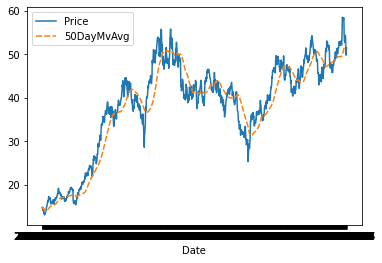

In [364]:
#SANITY CHECK#

#Time for a sanity check. If any of this makes sense, a graph of a stock's performance against
#its moving average should have higher peaks, lower valleys, and generally be smoother. Let's take advantage of
#some graphing utilities to examine this. 

# #import matplotlib.plyplot as plt
import seaborn as sns

aal_data = master_df.loc['AAL'].drop(columns=['Volume'])

plt = sns.lineplot(data = aal_data)

In [365]:
#This is pretty much exactly what we'd expect the graph to look like. Moving on. Let's give ourselves a 100 day
#moving average also, just for variety.

master_df['100DayMvAvg'] = generate_mvavg_column(100) 

In [367]:
filename = '100DayMvAvg.p'
with open(os.path.join(directory, filename), 'wb') as file:
    pickle.dump(master_df['100DayMvAvg'], file)

In [366]:
filename = 'master_df.p'
with open(os.path.join(directory, filename), 'wb') as file:
    pickle.dump(master_df, file)

In [368]:
#On its own, the moving average doesn't tell us much except where a stock used to be. 
#What we actually need is to relate the stocks current price movements with a lagging indicator such as
#the moving average, in order to tell us when it seems to be "breaking out" of its trend.

#We don't need to get fancy here. Simply using the ratio of its current price to its moving average will 
#yield such an indicator, as well as having the convenient effect of normalizing everything to 1.

master_df['50DayAvgRatio'] = master_df['Price'] / master_df['50DayMvAvg']
master_df['100DayAvgRatio'] = master_df['Price'] / master_df['100DayMvAvg']

In [369]:
print(master_df)

                      Price        Volume  50DayMvAvg  100DayMvAvg  \
Name Date                                                            
AAL  2013-02-08   14.750000  8.407500e+06   14.750000    14.750000   
     2013-02-11   14.460000  8.882000e+06   14.750000    14.750000   
     2013-02-12   14.270000  8.126000e+06   14.605000    14.605000   
     2013-02-13   14.660000  1.025950e+07   14.493333    14.493333   
     2013-02-14   13.990000  3.187990e+07   14.535000    14.535000   
...                     ...           ...         ...          ...   
SPY  2018-02-01  114.575660  4.890722e+06  110.097245   106.963104   
     2018-02-02  112.436766  5.470713e+06  110.283899   107.099911   
     2018-02-05  108.312574  7.187073e+06  110.424512   107.205899   
     2018-02-06  109.886085  8.117498e+06  110.472862   107.267972   
     2018-02-07  109.533457  5.710445e+06  110.554170   107.346560   

                 50DayAvgRatio  100DayAvgRatio  
Name Date                               

In [370]:
master_df.Price.corr(master_df['100DayMvAvg'])

0.99483884659937

In [371]:
master_df.Price.corr(master_df['50DayMvAvg'])

0.9971286505760288

In [372]:
master_df['100DayAvgRatio'].std()

0.08306191450869535

In [ ]:
#It's worth nothing that, in raw magnitude, the moving averages just don't budge that much from real time
#price action. To amplify the signal from these vectors we may ultimately need to scale them up, depending on 
#what machine learning model we pick and how it ends up working. However, we're going to put a pin in that for now
#until we know how we're going to use these data. 

In [413]:
#Our penultimate secondary variable is the momentum indicator relative strength. It is extremely easy to compute,
#being simply the returns of the security divided by the returns of the index.

def relative_strength_column(source_df):
    '''Outputs a pandas series containing relative strength for entire dataframe.'''
    stonk_names = OrderedSet(source_df.index.get_level_values(0))
    num_stonks = len(stonk_names)
    source_df['Returns'] = returns_series(source_df)
    baseline_series = pd.Series(
        np.concatenate([source_df.loc['SPY'].Returns.values for i in range(num_stonks)]),
        index = source_df.index)
          
    rel_str_column = source_df.Returns / baseline_series
    return rel_str_column

In [415]:
#Finally, the computationally intensive part. We want some kind of sequence of data frames over which to train our
#model. 

len(master_df.loc['AAPL'])

1259

In [419]:
def generate_slice_indices(lookback_length, 
                           lookforward_length, 
                           offset, 
                           source_df):
    
    from ordered_set import OrderedSet
    stock_names = OrderedSet(source_df.index.get_level_values(0))
    first_stock_name = stock_names[0]
    
    #All stocks have the same number of records (because we purged all those that didn't.)
    #Thus we should be able to use the first stock to tell us the number of trading days
    #for the whole field. 
    num_days = len(source_df.loc[example])
    #Still, let's make sure this holds up. 
    if len(stock_names) * num_days != len(source_df):
        print('Inconsistent stock record lengths. Further data processsing needed.')
        return None
    
    elif lookback_length + lookforward_length > num_days:
        print(f'Desired sample size exceeds length of dataset. Please make sure \n
            lookback_length + lookforward_length <= {num_days}')
    else:
        slice_indices = []
        end_tail = lookback_length + lookforward_length + num_days % offset
        valid_start_domain = num_days - end_tail
        starting_points = [j for j in range(valid_start_domain) if not j % offset]
        for i in starting_points:
            k = i + lookback_length
            index_tuple = (k - lookback_length, k, k + lookforward_length)
            slice_indices.append(index_tuple)
         
    return slice_indices
            

251.8

In [ ]:
def generate_sample(slice_index, source_df = source_df):
    from ordered_set import OrderedSet
    stock_names = OrderedSet(source_df.index.get_level_values(0))
    lookforward_samples = pd.DataFrame()
    lookbackward_samples = pd.DataFrame()
    
    for name in stock_names:
        single_stock = source_df.loc[name]
        lookbackward_sample = single_stock.iloc[slice_index[0]:slice_index[1]]
        lookbackward_samples = lookbackward_samples.append(lookbackward_sample)
        
        lookforward_sample = single_stock.iloc[slice_index[1], slice_index[2]]
        lookforward_samples = lookforward_samples.append(lookforward_sample)
        
    return lookbackward_samples, lookforward_samples 

In [ ]:
def generate_samples_dict(lookback_length, lookforward_length, offset = 5, source_df=master_df):
    slice_indices = generate_slice_indices(lookback_length, lookforward_length, offset, source_df)
    samples_dict = dict()
    for i, sample_type in enumerate(['backward', 'forward']):
        samples_dict[sample_type] = dict()
        for slice_index in slice_indices:
            sample[sample_type] = generate_sample(slice_index)[i]
            